In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
from IPython.display import display, HTML

display(HTML("""
<style>
    /* Center all outputs */
    div.jp-OutputArea {
        align-items: center;
        display: flex;
        justify-content: center;
    }

    img {
        display: block;
        margin-left: auto;
        margin-right: auto;
        max-width: 100%;
    }
    
    # .jp-Notebook {
    #         width: 75% !important;
    #         max-width: 1100px;
    #         margin: auto;
    #         border-style: groove;
    #     }
</style>
"""))


In [165]:
df = pd.read_csv("mortality_by_latitude.csv")
print("Shape: ", df.shape)
print(df.info())
df.head()

Shape:  (16, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         16 non-null     int64  
 1   mortality_index  16 non-null     int64  
 2   temperature      16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 516.0 bytes
None


,latitude,mortality_index,temperature
0,50,1025,51.3
1,51,1045,49.9
2,52,1004,50.0
3,53,959,49.2
4,54,870,48.5


make a plot of mortality index against mean average temperature. Is it hollow up or hollow down? Try to identify a transformation of one of the variables that will straighten out the relationship, and make a plot of the residuals to check for any remaining patterns.

In [167]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df['temperature'].to_frame(), df['mortality_index'])

LinearRegression()

In [168]:
print(f"Slope: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

Slope: 23.576945334311638
Intercept: -217.94690600195963


In [169]:
temperature_range = pd.DataFrame({'temperature': np.linspace(df['temperature'].min(), df['temperature'].max(), 100)})

temperature_range['pred'] = model.predict(temperature_range[['temperature']])

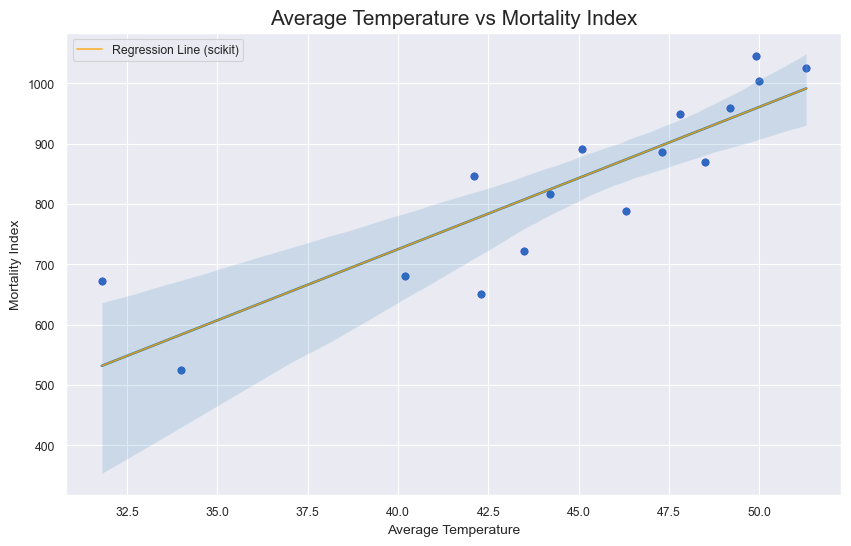

In [170]:
sns.set_context("paper")
sns.set_style("darkgrid")
fig,ax = plt.subplots(1,1, figsize=(10,6))
sns.scatterplot(df, x="temperature", y="mortality_index", ax=ax, s=40, color="#8629ff")
sns.regplot(df, x="temperature", y="mortality_index")
sns.lineplot(temperature_range, x="temperature", y="pred", label="Regression Line (scikit)", color="orange", alpha=0.8)

plt.title("Average Temperature vs Mortality Index", fontsize=15)
plt.ylabel("Mortality Index", fontsize=10)
plt.xlabel("Average Temperature", fontsize=10)
plt.legend();

In [171]:
y_pred = model.predict(df['temperature'].to_frame())
resid = df['mortality_index'] - y_pred

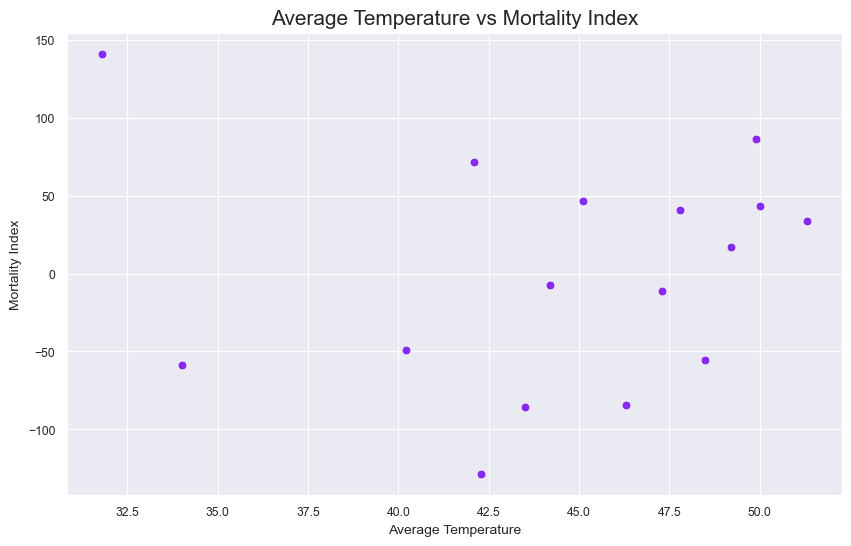

In [182]:
fig,ax = plt.subplots(1,1, figsize=(10,6))

sns.scatterplot(x=df["temperature"], y=resid, ax=ax, s=40, color="#8629ff")
# sns.regplot(df, x="temperature", y="mortality_index", label="Regression Line (sns)")
# sns.lineplot(temperature_range, x="temperature", y="pred", label="Regression Line (scikit)", color="orange", alpha=0.8)

plt.title("Average Temperature vs Mortality Index", fontsize=15)
plt.ylabel("Mortality Index", fontsize=10)
plt.xlabel("Average Temperature", fontsize=10);

As we can see from the figure above, we got ourselves a pretty good linear relationship. It is also clear that the data points shows a clear upward trend, resembling a "hollow up" shape (concave up). The data `moratlity_index` seemed to accelerate as the temperature increases. For that reason, we can appply box cox transformation of negative tau to 'straighten up' the data points.

In [14]:
def box_cox(X, tau):
    if tau == 0:
        return np.log(X)
    else:
        return ((X**tau) - 1)/tau

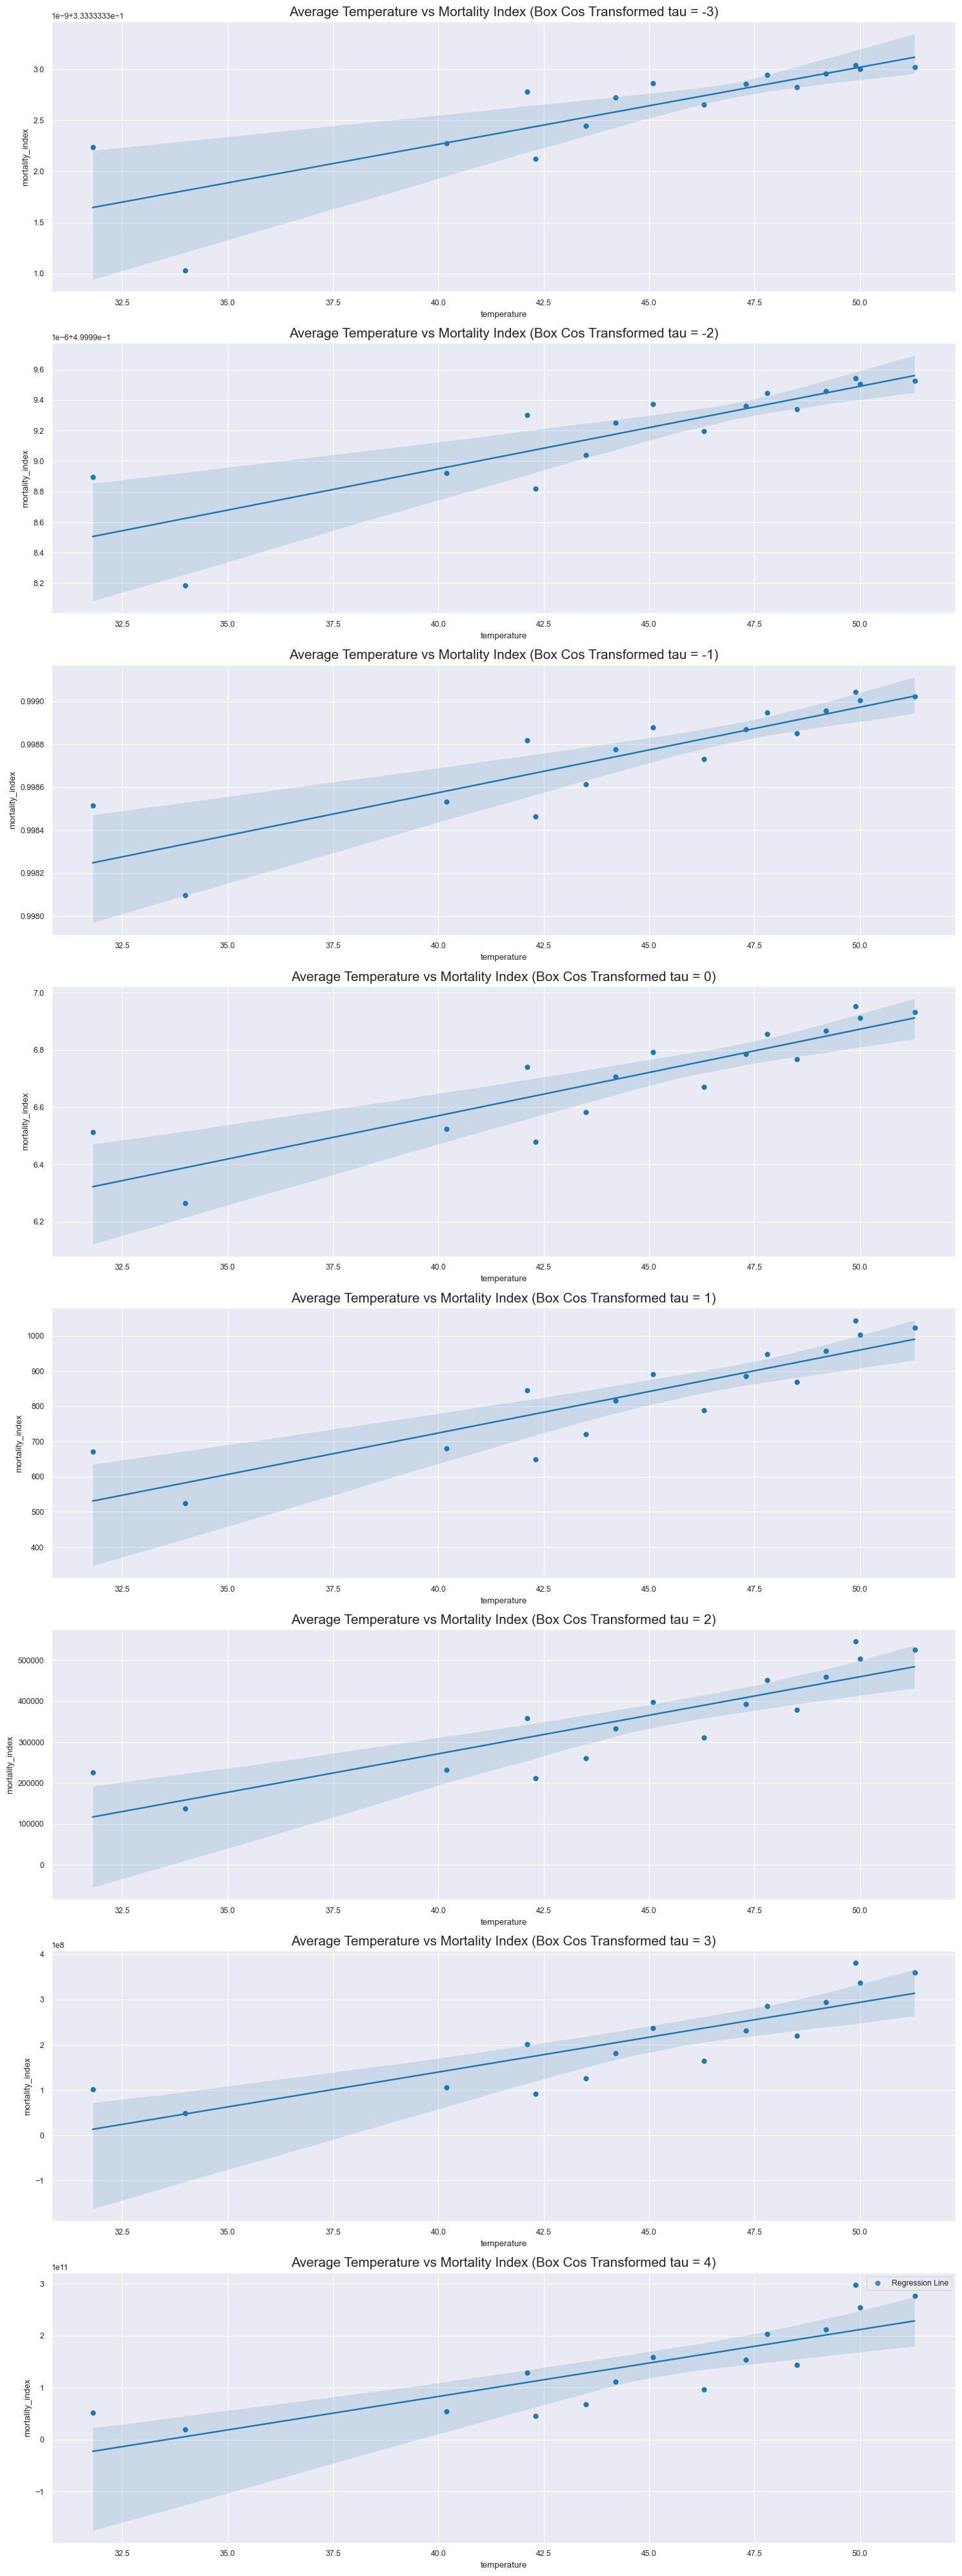

In [184]:
# log_transform = [np.log, np.log1p, np.log2]
pallete = ["#c71e48", "#9f1ec7", "#291ec7", "#641ec7"]
n=8
fig, ax = plt.subplots(ncols=1, nrows=n, figsize=(15,5*n))
ax = ax.flatten()
transformed_data = {}
for i in range(n):
    box_cox_res = box_cox(df['mortality_index'].astype(float), tau=i-3)
    transformed_data[i] = box_cox_res
    sns.scatterplot(x=df['temperature'], y=box_cox_res, ax=ax[i], s=40)
    sns.regplot(x=df['temperature'], y=box_cox_res, ax=ax[i], label="Regression Line")
    ax[i].set_title(f"Average Temperature vs Mortality Index (Box Cos Transformed tau = {i-3})", fontsize=15)

plt.tight_layout()
plt.legend();

In [186]:
resid = {}
for index, value in transformed_data.items():
    model = LinearRegression()
    model.fit(df['temperature'].to_frame(), value)
    y_pred = model.predict(df['temperature'].to_frame())
    resid[index] = value - y_pred

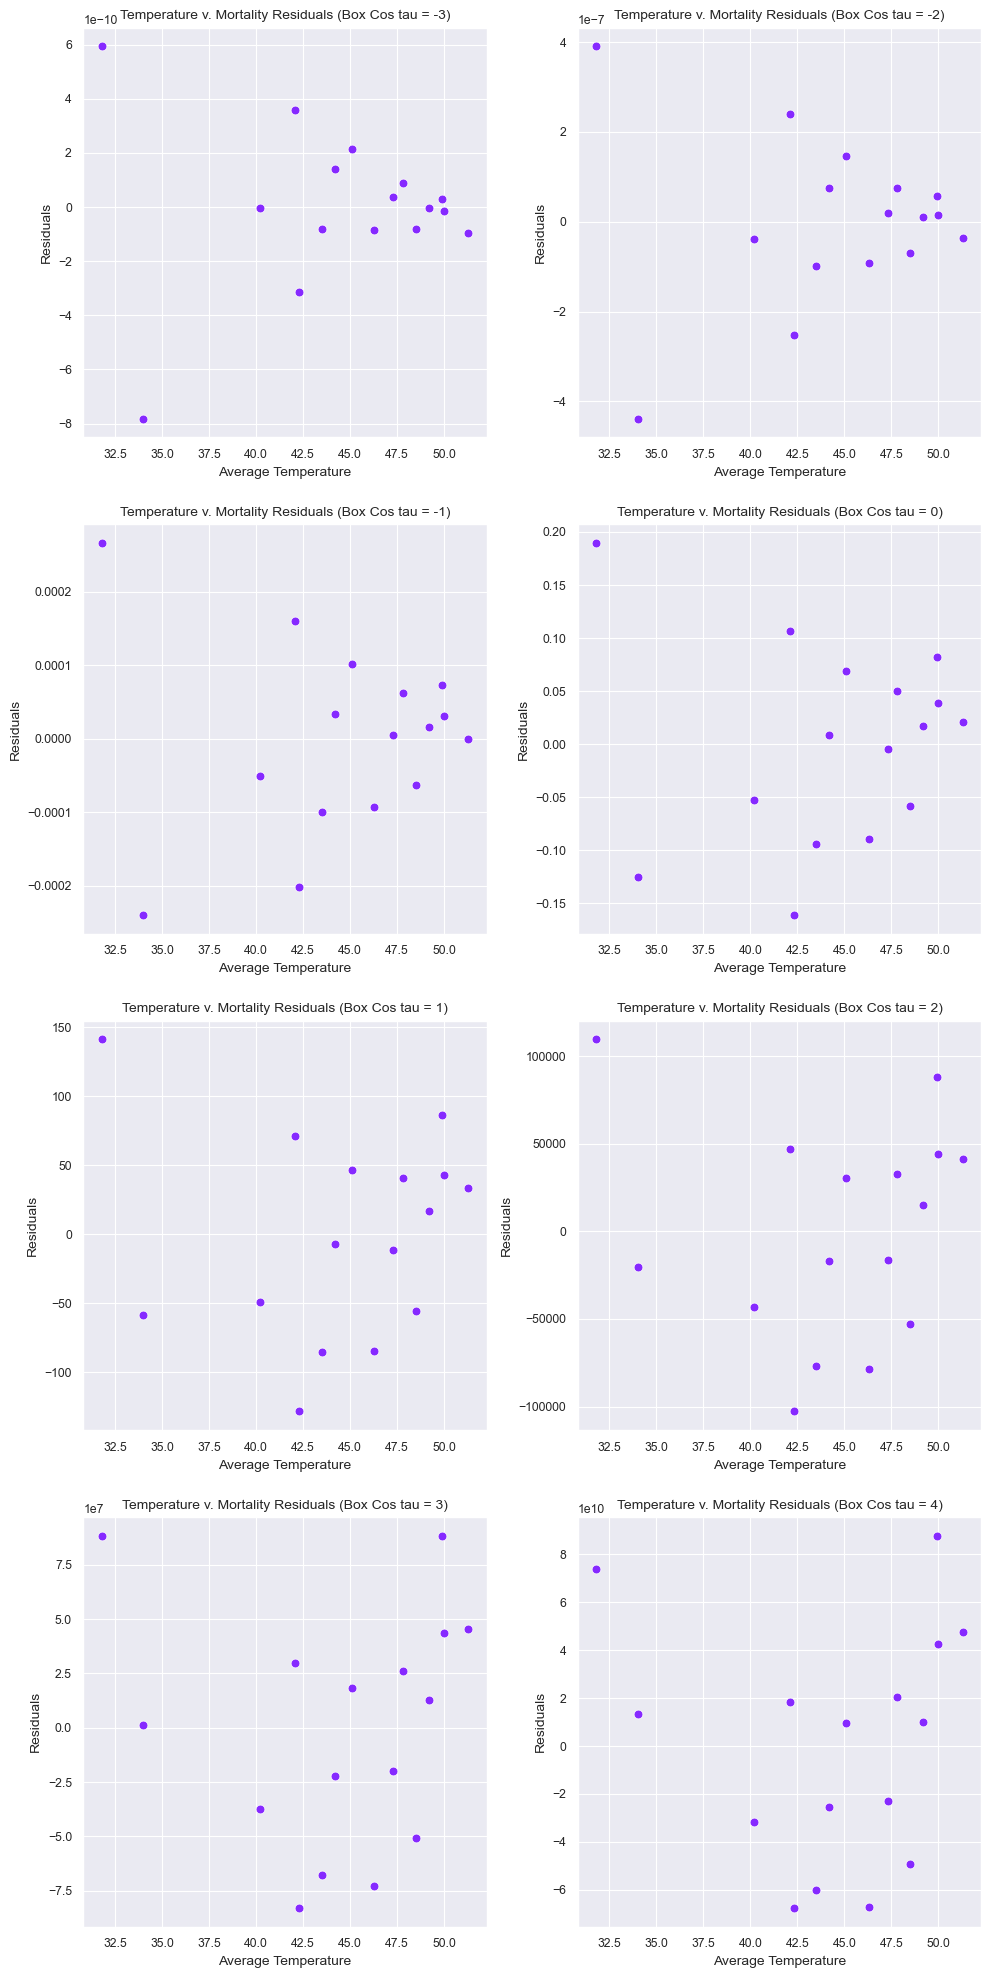

In [32]:
n = len(resid)

fig,ax = plt.subplots(ncols=2,nrows=n//2, figsize=(10,5*(n//2)))
ax = ax.flatten()

for i in range(len(ax)):
  sns.scatterplot(x=df["temperature"], y=resid[i], ax=ax[i], s=40, color="#8629ff")
  ax[i].set_title(f"Temperature v. Mortality Residuals (Box Cos tau = {i-3})", fontsize=10)
  ax[i].set_ylabel("Residuals", fontsize=10)
  ax[i].set_xlabel("Average Temperature", fontsize=10)

plt.tight_layout();

As we can see from residuals, it is clear that the negative $\tau$ proves to be more effective in straightening out the data points and controlling the variances of residuals.

In [34]:
diamonds = pd.read_csv("diamonds.csv")
print("Shape: ", diamonds.shape)
print(diamonds.info())
diamonds.head()

Shape:  (53940, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB
None


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [35]:
del diamonds['Unnamed: 0']

Using the same subset of the diamonds dataset, make a plot of log price as a function of carat with a loess smoother. Try several values for the span and degree arguments and comment briefly about your choice.

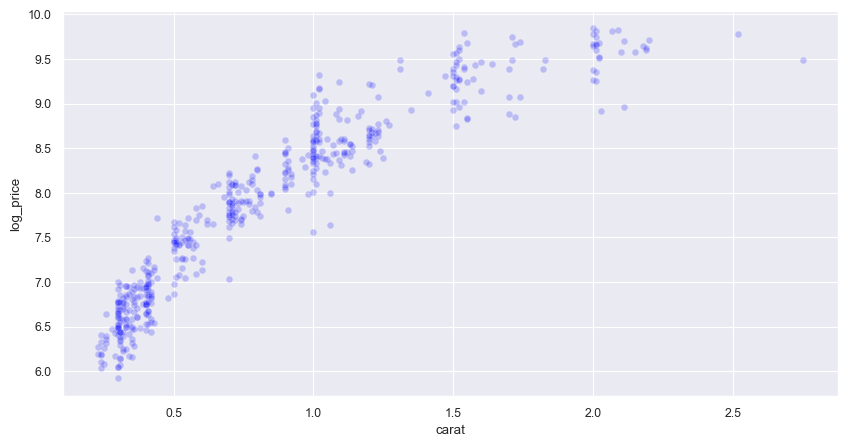

In [190]:
plt.figure(figsize=(10,5))
diamonds_subset = diamonds.sample(n=500, random_state=42)
diamonds_subset['log_price'] = np.log(diamonds_subset['price'])
sns.scatterplot(diamonds_subset, x="carat", y="log_price", color="blue", alpha=0.2);

In [38]:
from loess.loess_1d import loess_1d

In [39]:
xout, yout, weights = loess_1d(x=diamonds_subset['carat'].values, y=diamonds_subset['log_price'].values, degree=1,frac=0.5) 

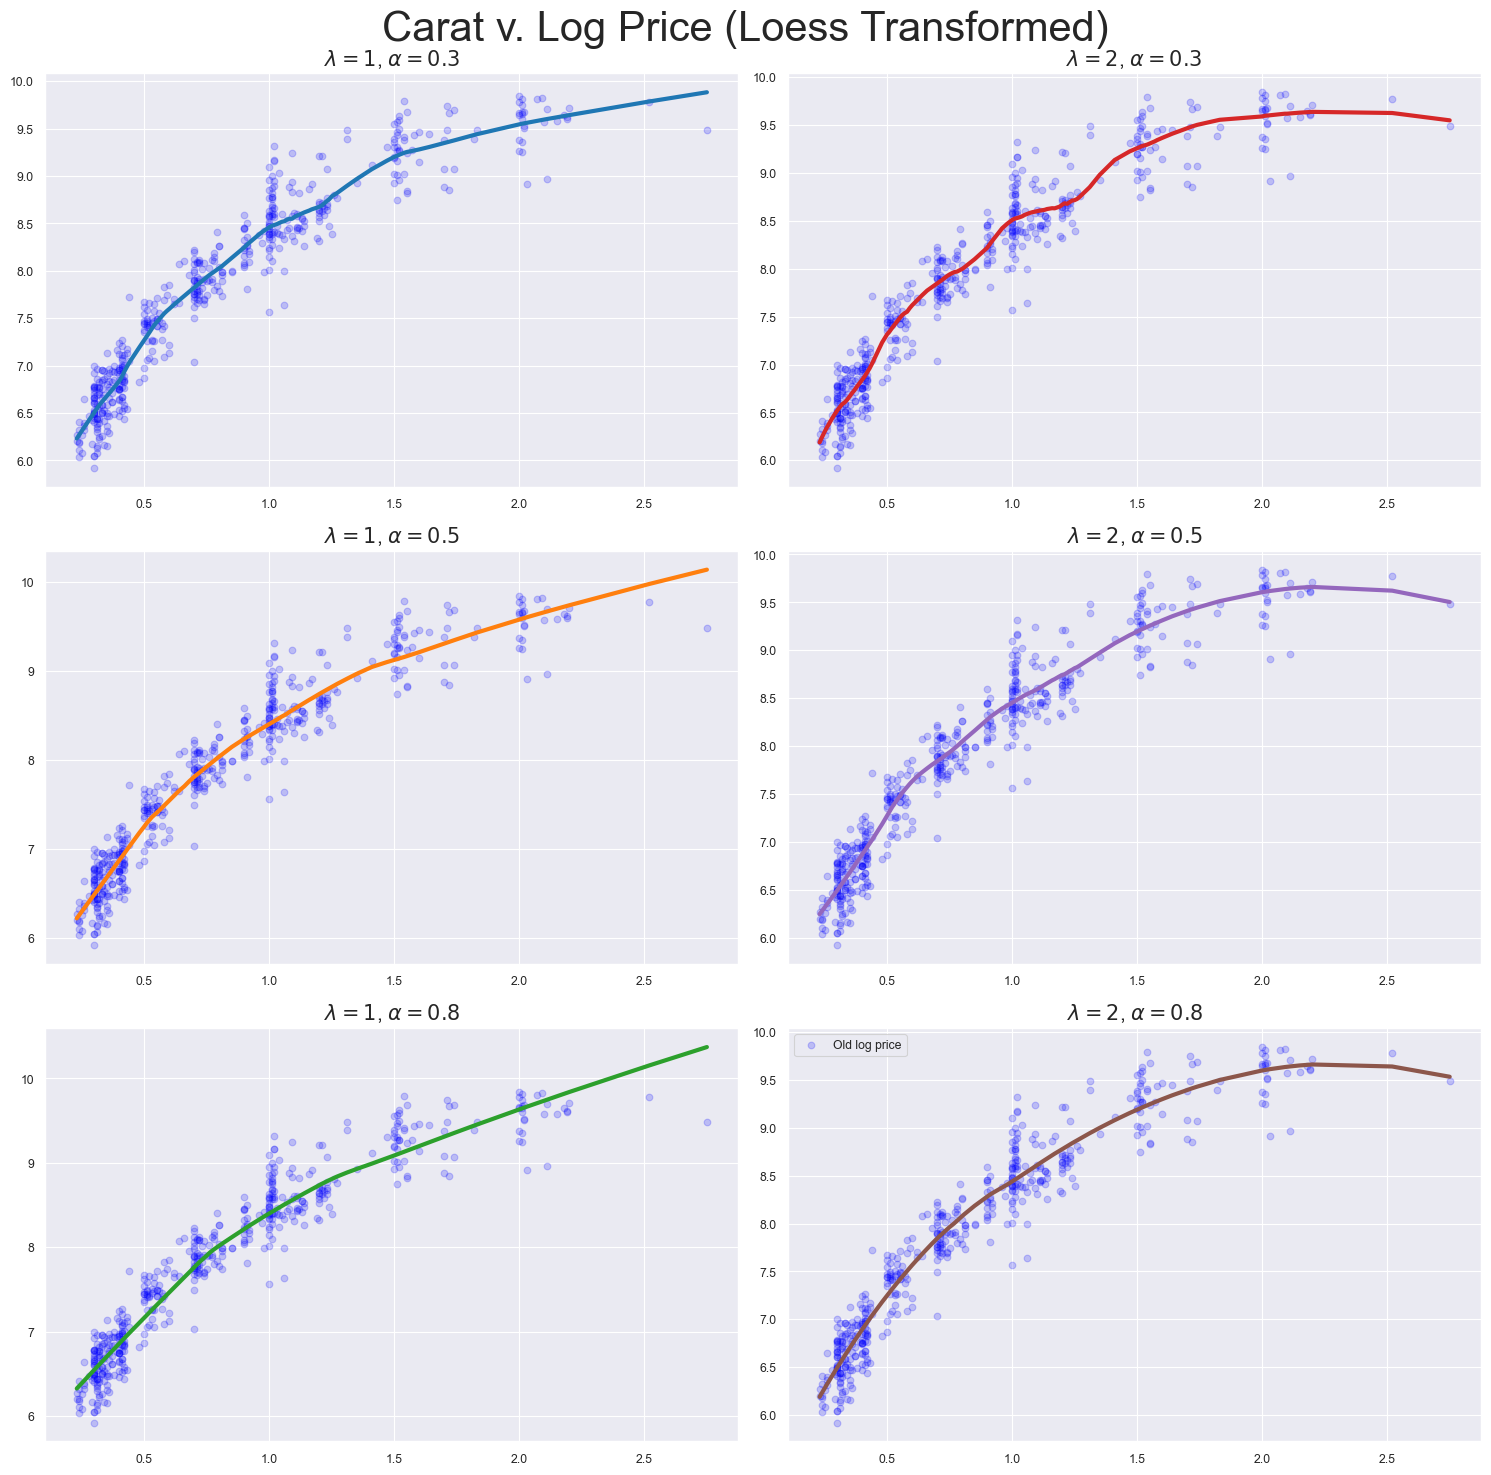

In [192]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
lambda_ = [1,2]
spans = np.array([0.30, 0.50, 0.80])

total_plots = len(lambda_) * len(spans)
colors = sns.color_palette("tab10", total_plots)

for ind_l,lamb in enumerate(lambda_):
    for ind_s, span in enumerate(spans):
        xout, yout, weights = loess_1d(x=diamonds_subset['carat'].values, y=diamonds_subset['log_price'].values, degree=lamb,frac=span)
        
        sorted_indices = np.argsort(xout)
        xout_sorted = xout[sorted_indices]
        yout_sorted = yout[sorted_indices]

        color_index = ind_l * len(spans) + ind_s
        color = colors[color_index]
        
        axes[ind_s][ind_l].scatter(x=diamonds_subset["carat"], y=diamonds_subset["log_price"], color="blue", alpha=0.2, label="Old log price")
        axes[ind_s][ind_l].plot(xout_sorted, yout_sorted, linewidth=3, color=color)
        axes[ind_s][ind_l].set_title(f'$\\lambda={lamb}$, $\\alpha={span}$', fontsize=15)
        
fig.suptitle("Carat v. Log Price (Loess Transformed)", fontsize=30)
plt.tight_layout()
plt.legend();

$\alpha=2$ and $\lambda=0.5$ seemed like a promising compromise between underfitting that are present on higher $\alpha$ and overfitting that could be observed on lower levels of $\alpha$. 

But to be quantitively precise let us cross validation and get the MSE for each fitting.

In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def loess_fit_pred(X, y, X_test, degree, span):
    '''fit loess and returns y-pred using interpolation'''
    xout, yout, weights = loess_1d(x=X, y=y, degree=degree,frac=span)
        
    sorted_indices = np.argsort(xout)
    xout_sorted = xout[sorted_indices]
    yout_sorted = yout[sorted_indices]

    return np.interp(X_test, xout_sorted, yout_sorted)


def cv_loess(X, y, degree, span, n_fold=10):
    k_obj = KFold(n_fold, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, test_index in k_obj.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_pred = loess_fit_pred(X_train, y_train, X_test, degree, span)

        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    mse_scores = np.array(mse_scores)
    return {"degree" : degree, "span" : span, "mean": mse_scores.mean(), "std" : mse_scores.std()}

spans = np.arange(0.1, 0.91, 0.10)
lambda_ = [1,2]
cv_scores = []

X, y = diamonds_subset['carat'].values, diamonds_subset['log_price'].values

for ind_l,lamb in enumerate(lambda_):
    for ind_s, span in enumerate(spans):
        result = cv_loess(X, y, degree=lamb, span=span)
        cv_scores.append(result)

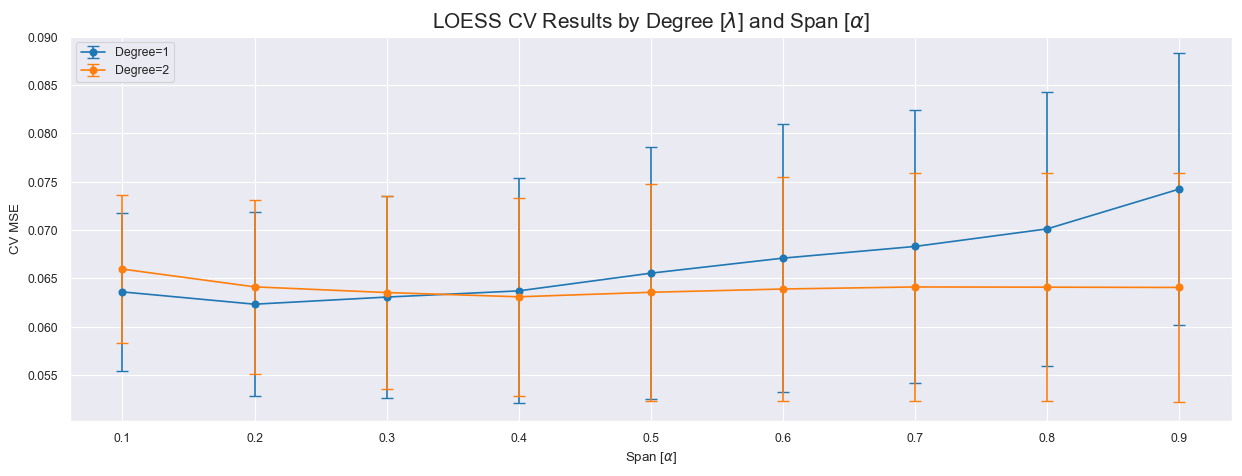

In [85]:
cv_scores_df = pd.DataFrame(cv_scores)
# cv_scores_melted = cv_scores_df.melt(id_vars=['degree', 'span'])
# cv_scores_melted
fig, ax = plt.subplots(figsize=(15, 5))

for deg in cv_scores_df["degree"].unique():
    sub = cv_scores_df[cv_scores_df["degree"] == deg]
    ax.errorbar(
        x=sub["span"],
        y=sub["mean"],
        yerr=sub["std"], 
        capsize=4,             
        marker="o",
        label=f"Degree={deg}"
    )

ax.set_xlabel("Span [$\\alpha$]")
ax.set_ylabel("CV MSE")
ax.set_title("LOESS CV Results by Degree [$\\lambda$] and Span [$\\alpha$]", fontsize=15)
ax.legend()
plt.show()

Based on the graph above, it appears as the $\lambda=2$ produces more consistent, low MSE, for all values of $\alpha$, especially for $\alpha \geq 0.4$. On $\lambda=1$, however, we have $\alpha=0.2$ that produces the lowest MSE. So the choices could either be $\lambda = 1$ with $\alpha=0.2$ or $\lambda=2$ with $\alpha=0.4$. Since an $\alpha=0.2$ is too flexible for my subjective liking because may it be prone to overfitting, it is wise to choose a moderate values of $\alpha$ like $\alpha=0.4$. It's the safer choice of the two even if its MSE is slightly higher (although on a neglible difference).

In [91]:
xout, yout, weights = loess_1d(x=X, y=y, degree=2,frac=0.4)
        
sorted_indices = np.argsort(xout)
xout_sorted = xout[sorted_indices]
yout_sorted = yout[sorted_indices]

y_pred_loess = np.interp(X, np.sort(xout), yout[np.argsort(xout)])

In [95]:
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly.fit_transform(X.reshape(-1, 1))

binning = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='uniform')
x_bins = binning.fit_transform(X.reshape(-1, 1))

from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model.fit(np.hstack([x_poly, x_bins]), y)

y_pred_poly = model.predict(np.hstack([x_poly, x_bins]))

In [97]:
residuals_loess = y - y_pred_loess
residuals_poly = y - y_pred_poly

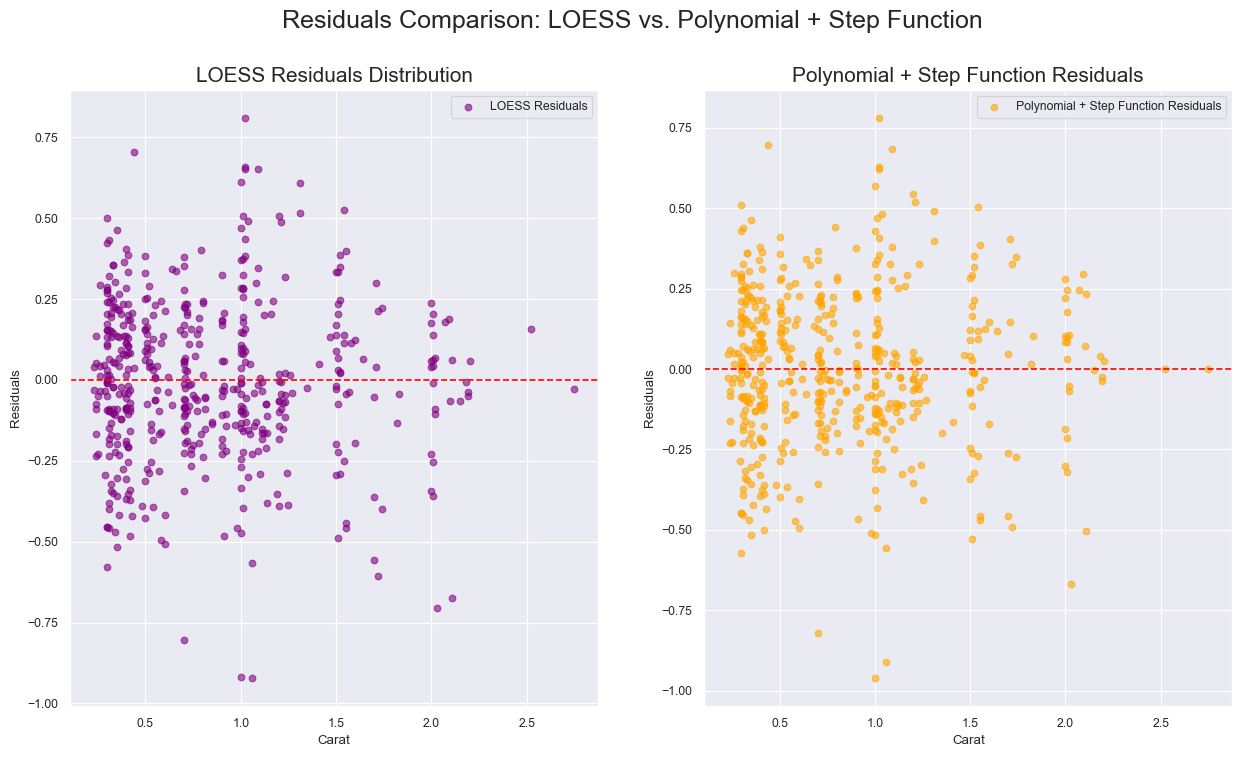

In [200]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,8))

ax[0].scatter(X, residuals_loess, alpha=0.6, label='LOESS Residuals', color='purple')
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Carat')
ax[0].set_ylabel('Residuals')
ax[0].set_title("LOESS Residuals Distribution", fontsize=15)
ax[0].legend()


ax[1].scatter(X, residuals_poly, alpha=0.6, label='Polynomial + Step Function Residuals', color='orange')
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_xlabel('Carat')
ax[1].set_ylabel('Residuals')
ax[1].set_title("Polynomial + Step Function Residuals", fontsize=15)
ax[1].legend()

fig.suptitle('Residuals Comparison: LOESS vs. Polynomial + Step Function', fontsize=18);
plt.show();

We have a close one here because both `LOESS` and `Polynomial + Step Function Model` are evenly distributed around $resid=0$ and there's no discernable pattern left in the residuals of both models. But using a subjective guestimation, we can approximate that the `Polynomial + Step Function Residuals` is slighly better. Although the difference isn't that clear so we can't be wrong with picking one over the other.

In [121]:
mse_loess = mean_squared_error(y, y_pred_loess)
mse_poly = mean_squared_error(y, y_pred_poly)

print(f"MSE for LOESS Model: {mse_loess:.4f}")
print(f"MSE for Polynomial + Step Function Model: {mse_poly:.4f}")

MSE for LOESS Model: 0.0608
MSE for Polynomial + Step Function Model: 0.0596
